In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt','r').read().splitlines()

In [3]:
chars = ['.'] + sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}

In [43]:
block_size = 3
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [44]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [45]:
C = torch.randn((27, 2))

In [46]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [47]:
W1 = torch.randn(6, 100)
b1 = torch.randn(100)

In [16]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h

tensor([[ 0.8071,  0.4461, -0.7762,  ..., -0.5304,  0.4093, -0.7249],
        [ 0.8174, -0.6750, -0.4445,  ..., -0.1072,  0.5450, -0.5550],
        [ 0.9819, -0.9852, -0.8367,  ...,  0.7700,  0.9983, -0.9134],
        ...,
        [-0.5036,  0.9857,  0.4783,  ..., -0.6246, -1.0000, -0.7358],
        [ 0.4804, -0.9808,  0.9974,  ..., -1.0000, -0.8614,  1.0000],
        [-0.4223,  0.8503, -0.8132,  ..., -0.7649,  0.9977, -0.8028]])

In [17]:
h.shape

torch.Size([32, 100])

In [18]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [19]:
logits = h @ W2 + b2

In [20]:
logits.shape

torch.Size([32, 27])

In [21]:
counts = logits.exp()

In [22]:
prob = counts / counts.sum(1, keepdims=True)

In [23]:
prob.shape

torch.Size([32, 27])

In [25]:
loss = -prob[torch.arange(32), Y].log().mean()

In [26]:
loss

tensor(16.0529)

In [27]:
#--------------------made cleaner---------------------------

In [48]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [103]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [104]:
sum(p.nelement() for p in parameters) # total number of parameters

3481

In [105]:
for p in parameters:
    p.requires_grad = True

In [106]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [117]:
lri = []
lossi = []

for i in range(10000):
    
    #minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = lrs[i]
    lr = 0.01
    #update
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())

print(loss.item())

2.1584548950195312


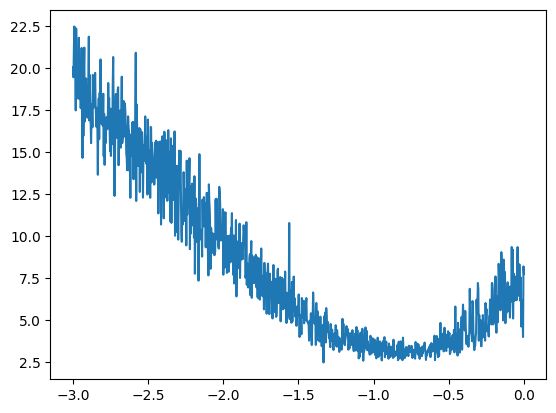

In [102]:
plt.plot(lri, lossi)

In [118]:
#model loss
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3110, grad_fn=<NllLossBackward0>)